[colab](https://colab.research.google.com/github/rufous86/studies/blob/main/DLS_NLP/05_language_modeling/hw_language_modelling.ipynb)

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы. 

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 7.5 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

from collections import Counter
from typing import List

import string


import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 1

import time

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence) if len(x) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 28827


Посчитаем для каждого слова его встречаемость.

In [ ]:
def count_words(dataset, remove_stops=False):
    words = Counter()
    if remove_stops:
        stops = stopwords.words('english')
    else:
        stops = []

    # Расчет встречаемости слов
    for example in tqdm(dataset):
        # Приводим к нижнему регистру и убираем пунктуацию
        processed_text = example.lower().translate(
            str.maketrans('', '', string.punctuation))
        processed_text = [
            word for word in word_tokenize(processed_text)
        ]

        for word in processed_text:
            words[word] += 1
    return words

words = count_words(dataset['train']['text'], remove_stops=False)

  0%|          | 0/25000 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab_size = 40000

vocab = set(dict(sorted(words.items(), key=lambda x: x[1], reverse=True)[:vocab_size]).keys())
for serv_word in ['<unk>', '<bos>', '<eos>', '<pad>']:
    vocab.add(serv_word)

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx].split(' ')]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> tuple[float, float]:
    model.eval()
    perplexity = []
    losses = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Validation'):
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1)) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten()).cpu().detach()
            perplexity.append(torch.exp(loss).item())
            losses.append(loss)
    
    perplexity = sum(perplexity) / len(perplexity)
    loss = sum(losses) / len(losses)

    return perplexity, loss.item()

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [ ]:
def train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                algo_desc) -> dict:
    # Напишите код здесь
    start = time.time()
    losses = []
    perplexities = []
    val_losses = []
    val_perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        epoch_perplexities = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1))
            loss = criterion(
                logits, batch['target_ids'].flatten())
            
            perplexity = torch.exp(loss).item()
            epoch_perplexities.append(perplexity)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(sum(epoch_perplexities) / len(epoch_perplexities))
        print('train_loss:', losses[-1])
        print('train_perplexity:', perplexities[-1])
            
        val_perplexity, val_loss = evaluate(model, criterion, val_dataloader)
        val_losses.append(val_loss)
        val_perplexities.append(val_perplexity)
        
        print('val_loss:', val_losses[-1])
        print('val_perplexity:', val_perplexities[-1])

    history = {
        'algo_desc': algo_desc,
        'train_loss': losses,
        'train_perplexity': perplexities,
        'val_loss': val_losses,
        'val_perplexity': val_perplexities,
        'execution_time': time.time() - start
        }
    return history

all_histories = []

Функция для вывода графиков

In [ ]:
def plot_result(history):
    print(history['algo_desc'])
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'][1:], c='r', label='train')
    plt.plot(history['val_loss'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'loss, best on val {min(history["val_loss"]):.5f}')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_perplexity'][1:], c='r', label='train')
    plt.plot(history['val_perplexity'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'perplexity, best on val {min(history["val_perplexity"]):.5f}')
    
    plt.show()

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

In [ ]:
class LanguageModelLinear(nn.Module):
    def __init__(
        self, embed_dim: int, 
        hidden_dim: int, 
        vocab_size: int,
        num_layers: int,
        gru_is_bidirectional: bool):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, 
                          hidden_dim, 
                          num_layers, 
                          bidirectional=gru_is_bidirectional,
                          batch_first=True)
        
        if gru_is_bidirectional:
            self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        else:
            self.linear = nn.Linear(hidden_dim, hidden_dim)

        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        x, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim] 
        x = self.dropout(self.linear(self.non_lin(x)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(x))  # [batch_size, num_classes]

        return prediction

In [ ]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=1,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history1 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с 1 GRU слоем')

all_histories.append(history1)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 4.037402973649251
train_perplexity: 809.195226247798


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.508779764175415
val_perplexity: 33.67706261693904


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.36524608648943
train_perplexity: 29.241532573383815


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.2704124450683594
val_perplexity: 26.528681982935


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.1696408532601037
train_perplexity: 23.99394280870975


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.1397743225097656
val_perplexity: 23.27197277440434


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.050095415905694
train_perplexity: 21.27359403431086


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.0555286407470703
val_perplexity: 21.385991611311923


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.9562498574757443
train_perplexity: 19.35595333246895


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9882707595825195
val_perplexity: 19.98688998264549


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.878192358912684
train_perplexity: 17.89448046815988


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9323573112487793
val_perplexity: 18.896908135540716


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.8075414889425203
train_perplexity: 16.664194865779983


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.8748021125793457
val_perplexity: 17.836859542711647


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.739717262225915
train_perplexity: 15.56598017887516


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.8343164920806885
val_perplexity: 17.128360081562953


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.6767350415498514
train_perplexity: 14.61332176798615


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.7770771980285645
val_perplexity: 16.171071331057927


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.619452720188963
train_perplexity: 13.80061280793248


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.7595813274383545
val_perplexity: 15.893788793445689


Попробуем увеличить количество скрытых слоев

In [ ]:
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history2 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с 2 GRU слоями')

all_histories.append(history2)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 4.101138695827506
train_perplexity: 741.8214415133988


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.60612416267395
val_perplexity: 37.13083554158169


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.4735866198882213
train_perplexity: 32.575005167755634


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.39544415473938
val_perplexity: 30.06441129836361


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.280558504452363
train_perplexity: 26.81228166653965


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.2317378520965576
val_perplexity: 25.516031771634534


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.130041026278754
train_perplexity: 23.05421519411203


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.1157710552215576
val_perplexity: 22.715966114955666


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.014417097713407
train_perplexity: 20.52211186108668


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.0406243801116943
val_perplexity: 21.06676620719707


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.9224826433381983
train_perplexity: 18.708264398311382


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9879865646362305
val_perplexity: 19.98344569079644


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.8445973514851945
train_perplexity: 17.294959026146987


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.94156813621521
val_perplexity: 19.07521647056647


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.779001034425767
train_perplexity: 16.19256559129578


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.86175537109375
val_perplexity: 17.597891512170303


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.7197913240991243
train_perplexity: 15.257103472124806


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.8323802947998047
val_perplexity: 17.091566870697832


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.647496837278756
train_perplexity: 14.186475448186885


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.8132259845733643
val_perplexity: 16.772807661410983


Попробуем Bidirectional GRU

In [ ]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=1,
                            gru_is_bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history3 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с Bidirectional GRU слоем')

all_histories.append(history3)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.4335781250210755
train_perplexity: 587.1383796291457


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.298156261444092
val_perplexity: 10.029946327209473


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.7532882130607057
train_perplexity: 6.112807832370147


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.2316793203353882
val_perplexity: 3.4452959626121857


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.0321674728920447
train_perplexity: 2.8568818121325243


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.7672346830368042
val_perplexity: 2.162267940234294


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.6807828130643012
train_perplexity: 1.9915395632633188


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.5281601548194885
val_perplexity: 1.7008012976266642


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.4749602239105583
train_perplexity: 1.6150696047103208


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.38851451873779297
val_perplexity: 1.4782655798228441


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.335790506795625
train_perplexity: 1.402633865893875


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.2926580011844635
val_perplexity: 1.3425607185448165


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.23678764235742844
train_perplexity: 1.2690048039947426


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.22489576041698456
val_perplexity: 1.2541627461931346


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.16181766400268063
train_perplexity: 1.1765767270030238


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.177800714969635
val_perplexity: 1.1963132598758799


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.10420226891272964
train_perplexity: 1.1102323196210915


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.1483524590730667
val_perplexity: 1.161580664921651


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.061490011560982764
train_perplexity: 1.0635766838136957


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.12810826301574707
val_perplexity: 1.1383471815986972


Попробуем 2 слоя Bidirectional GRU

In [ ]:
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history4 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с 2 Bidirectional GRU слоями')

all_histories.append(history4)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.646714435756536
train_perplexity: 486.9881063060866


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.803591012954712
val_perplexity: 16.64472413696019


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.573715844865662
train_perplexity: 13.355643082718823


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.334843397140503
val_perplexity: 10.402894775424384


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.253562162594242
train_perplexity: 9.627656849708346


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.1051104068756104
val_perplexity: 8.263518848250397


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.0071942055422958
train_perplexity: 7.534444777346447


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.8189777135849
val_perplexity: 6.204740372379269


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.7048121111169046
train_perplexity: 5.572171539232876


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.499277949333191
val_perplexity: 4.5043551309973795


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.3707081711753297
train_perplexity: 3.9931299844499453


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.1451539993286133
val_perplexity: 3.1587100071189678


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.012968581355079
train_perplexity: 2.7875946417697883


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.8076450824737549
val_perplexity: 2.251512318585826


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.7237432671515323
train_perplexity: 2.0777621137503104


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.58788001537323
val_perplexity: 1.8060185508390443


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.5309736025596851
train_perplexity: 1.7082147953918625


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.45599085092544556
val_perplexity: 1.5819704564271775


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.4005451606617448
train_perplexity: 1.4968034121213039


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.37082669138908386
val_perplexity: 1.4523441654390994


### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

Попробуем в первой модели с 1 слоем скрытого состояния и однонаправленным GRU добавить сверточный слой перед GRU

In [ ]:
class LanguageModelConvBeforeGRU(nn.Module):
    def __init__(self, vocab_size: int, 
                 embed_dim: int, 
                 hidden_dim: int, 
                 kernel_size: int,
                 b_norm: bool):
        super().__init__()
        self.b_norm = b_norm
        self.norm = nn.BatchNorm1d(hidden_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, hidden_dim, kernel_size, padding='same')
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(0)
        x = x.permute(0, 2, 1) # swap dimensions for Conv1d
        x = self.conv(x)
        x = nn.functional.relu(x)

        if self.b_norm:
            x = self.norm(x)

        x = x.permute(0, 2, 1) # swap dimensions back
        x = x.squeeze(0)
        x, _ = self.gru(x)
        x = self.fc(x)
        return x


In [ ]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3,
                          b_norm=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history5 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Conv Before GRU')

all_histories.append(history5)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.5265766151702205
train_perplexity: 504.2460121515706


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.1548908948898315
val_perplexity: 3.1903148984487077


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.8572251017910341
train_perplexity: 2.4057227616810666


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.5906668305397034
val_perplexity: 1.811327371977072


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.49330184802166005
train_perplexity: 1.648114309126501


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.37843337655067444
val_perplexity: 1.463342592779514


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.3119533099851556
train_perplexity: 1.3700662950125848


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.2628977298736572
val_perplexity: 1.302785776357735


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.20131851065883322
train_perplexity: 1.2248210656708776


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.19775666296482086
val_perplexity: 1.220267245199828


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.12956641877883046
train_perplexity: 1.1391963016920985


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.15030640363693237
val_perplexity: 1.163457595141588


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.07767060957849026
train_perplexity: 1.0811588138506558


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.12123936414718628
val_perplexity: 1.1300977310248181


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.04241629137827382
train_perplexity: 1.0434763609375084


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.09801991283893585
val_perplexity: 1.104099422429515


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.021825767981495648
train_perplexity: 1.0221063050117283


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.08402963727712631
val_perplexity: 1.0887367704273325


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.011538044868541356
train_perplexity: 1.0116126168498676


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.07718160003423691
val_perplexity: 1.0812831557957472


Добавим слой батч нормализации после сверток

In [ ]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3,
                          b_norm=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history6 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Conv Before GRU с батч нормализацией')

all_histories.append(history6)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.0662646537327634
train_perplexity: 565.7338814327071


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.7420060038566589
val_perplexity: 2.1089758957381797


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.5528763377864058
train_perplexity: 1.7578196380678461


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.36290380358695984
val_perplexity: 1.4407466808251574


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.28586871164609057
train_perplexity: 1.3353380037276126


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.2185320109128952
val_perplexity: 1.2459744067318672


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.1504221640486085
train_perplexity: 1.1637492324765875


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.14511223137378693
val_perplexity: 1.1573375980410956


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.07219581825668969
train_perplexity: 1.0753690471965305


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.09978383779525757
val_perplexity: 1.1058943651418771


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.026099061894420926
train_perplexity: 1.0265538007514912


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.07769815623760223
val_perplexity: 1.0817295692663278


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.008172779547266704
train_perplexity: 1.008212657264583


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0711250975728035
val_perplexity: 1.0746737718582153


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.004184235670753029
train_perplexity: 1.004193635276668


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.06936797499656677
val_perplexity: 1.0727947982011643


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.002926569361913723
train_perplexity: 1.0029310587361373


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0685473382472992
val_perplexity: 1.0719208453608826


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0022543301942207702
train_perplexity: 1.0022569802584569


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0680650845170021
val_perplexity: 1.0714103036222205


Language Model Linear с 1 GRU слоем


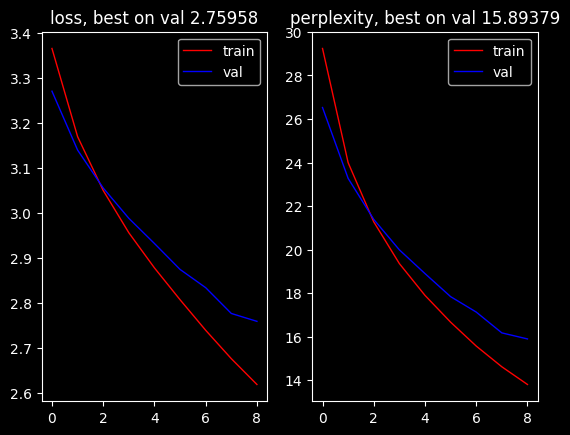

Language Model Linear с 2 GRU слоями


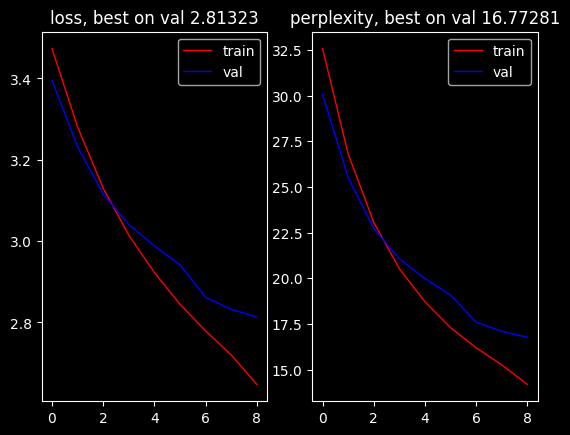

Language Model Linear с Bidirectional GRU слоем


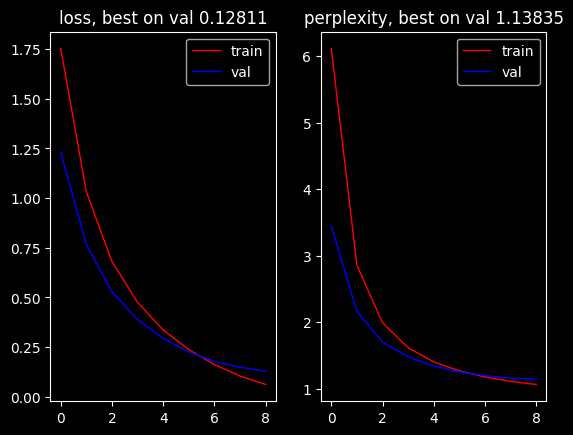

Language Model Linear с 2 Bidirectional GRU слоями


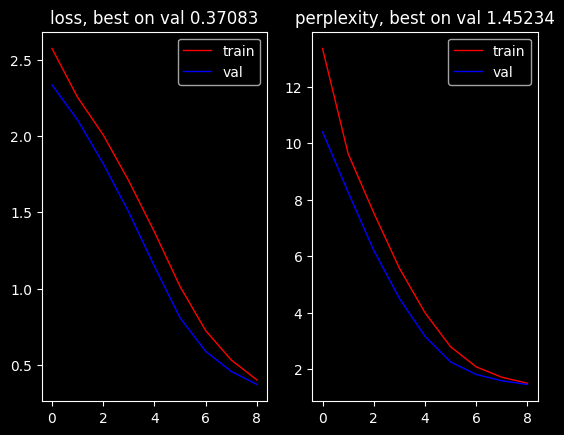

Language Model Conv Before GRU


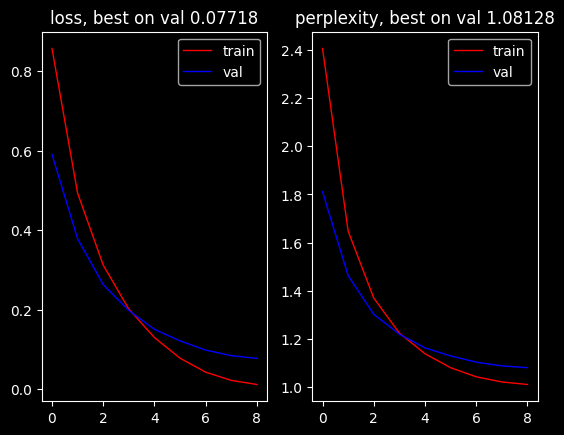

Language Model Conv Before GRU с батч нормализацией


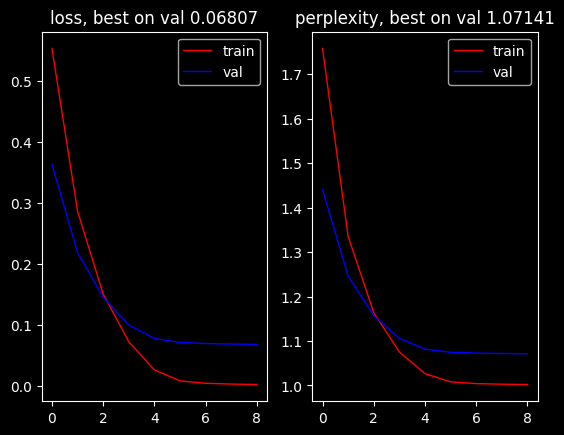

In [ ]:
for history in all_histories:
    plot_result(history)

Сравним время выполнения алгоритмов

In [ ]:
times = [(history['algo_desc'], history['execution_time']) for history in all_histories]

names, times = zip(*times)
plt.figure(figsize=(10, 20))
plt.scatter(names, times)

for name, time in zip(names, times):
    plt.annotate(name, (name, time))

plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 

In [ ]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 8) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

generate_sequence(model, starting_seq='when you think ')

'<bos> when you think crosby kissinger moments bud adrian moves complex attack'